In [1]:
import json
import yaml
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
config = yaml.safe_load(open("/gscratch/balazinska/enhaoz/VOCAL-UDF/configs/config.yaml", "r"))

import re
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [7]:
def plot(dataset, dataset_title, query_class_names, num_new_udfs, question_ids, run_ids, vocal_udf_config_name):
    # Define LLM models, tasks, number of new UDFs, and hatch patterns
    llm_models = ['visprog', 'equi-vocal', 'vocal-udf']
    llm_model_labels = ['VisProg', 'EQUI-VOCAL', 'SEVDA']

    hatch_patterns = ['...', '///', '\\\\\\', 'xxx', '***', '+++', '|||', '---', 'ooo']
    handles_f1 = []

    # Create a figure and axis for the boxplot
    fig, ax = plt.subplots(1, 1, figsize=(len(num_new_udfs), 2))  # Adjust the figsize as needed

    # Iterate through LLM models
    for i, llm_model in enumerate(llm_models):
        print(f"######## {llm_model} ########")
        f1_data = []

        # Iterate through tasks
        for task_id in num_new_udfs:
            task = f"{task_id}_new_udfs"
            f1_list = []
            failed_list = []

            # Iterate through runs and questions
            if llm_model in ["equi-vocal"]:
                for query_class_name in query_class_names:
                    for run_id in run_ids:
                        for question_id in question_ids:
                            try:
                                with open(os.path.join(config['log_dir'], "query_execution", dataset, query_class_name, f"num_missing_udfs={task_id}", llm_model, f"qid={question_id}-run={run_id}.log"), "r") as f:
                                    lines = f.readlines()
                                f1_score = -1
                                for line in lines:
                                    if "F1 score:" in line:
                                        f1_score_pattern = r"F1 score: ([0-9.]+)"
                                        match = re.search(f1_score_pattern, line)
                                        f1_score = float(match.group(1))
                                        failed_list.append(0)
                                        break
                                if f1_score == -1:
                                    print(f"failed task: qid={question_id}-run={run_id}")
                                    failed_list.append(1)
                                    f1_score = 0
                                f1_list.append(f1_score)
                            except Exception as e:
                                print(e)
                                continue

            elif llm_model in ['vocal-udf']:
                for query_class_name in query_class_names:
                    for run_id in run_ids:
                        for question_id in question_ids:
                            try:
                                with open(os.path.join(config['log_dir'], "query_execution", dataset, query_class_name, f"num_missing_udfs={task_id}", vocal_udf_config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                                    lines = f.readlines()
                                f1_score = -1
                                for line in lines:
                                    if "F1 score:" in line:
                                        f1_score_pattern = r"F1 score: ([0-9.]+)"
                                        match = re.search(f1_score_pattern, line)
                                        f1_score = float(match.group(1))
                                        failed_list.append(0)
                                        break
                                if f1_score == -1:
                                    print(f"failed task: qid={question_id}-run={run_id}")
                                    failed_list.append(1)
                                    f1_score = 0
                                f1_list.append(f1_score)
                            except Exception as e:
                                print(e)
                                continue
            else:
                for query_class_name in query_class_names:
                    for run_id in run_ids:
                        for question_id in question_ids:
                            try:
                                with open(os.path.join(config['log_dir'], "query_execution", dataset, query_class_name, f"num_missing_udfs={task_id}", "visprog-llm=gpt-4o", f"qid={question_id}-run={run_id}.log"), "r") as f:
                                    lines = f.readlines()
                                f1_score = -1
                                for line in lines:
                                    if "F1: " in line:
                                        f1_score_pattern = r"F1: ([0-9.]+)"
                                        match = re.search(f1_score_pattern, line)
                                        f1_score = float(match.group(1))
                                        failed_list.append(0)
                                        break
                                if f1_score == -1:
                                    print(f"failed task: qid={question_id}-run={run_id}")
                                    failed_list.append(1)
                                    f1_score = 0
                                f1_list.append(f1_score)
                            except Exception as e:
                                print(e)
                                continue

            f1_data.append(f1_list)
            print(f"task_{task}_mean_f1: {np.mean(f1_list)}")
            print(f"task_{task}_prob_failures: {np.mean(failed_list)}")
            print()

        # Create a grouped boxplot for F1 scores
        bp_f1 = ax.boxplot(f1_data,
                        positions=np.array(range(len(f1_data))) * (len(llm_models) + 1) + i,
                        sym='.',
                        widths=1,
                        showfliers=False,
                        patch_artist=True,
                        boxprops=dict(facecolor=CB_color_cycle[i], hatch=hatch_patterns[i]),
                        medianprops=dict(color='black'))
        handles_f1.append(bp_f1["boxes"][0])

    # Customize the plot labels and legend
    # ax.set_title(f"question_ids: {question_ids}")
    ax.set(ylabel="F1 Score")
    ax.set(xlabel="# missing UDFs")
    ax.set_ylim(bottom=0, top=1.05)
    ax.set_xlim(left=-1.5, right=len(num_new_udfs) * (len(llm_models)+1) - 0.5)
    ax.set_xticks(np.arange(len(llm_models) / 2 - 0.5, len(num_new_udfs) * len(llm_models) + len(llm_models) / 2 + 0.5, len(llm_models) + 1))
    ax.set_xticklabels(num_new_udfs)
    ax.set_title(f"{dataset_title}", fontsize=10)
    fig.tight_layout()
    fig.savefig(f"figures/eval_{dataset}.pdf", bbox_inches='tight')

    legendFig = plt.figure("Legend plot", figsize=(8, 1))
    legendFig.legend(handles_f1, llm_model_labels, loc='center', ncol=1, prop={"size": 10}, fancybox=True, shadow=False)
    legendFig.savefig('figures/end_to_end_legend.pdf', bbox_inches='tight')
    plt.gca().set_axis_off()
    plt.show()

######## visprog ########
task_0_new_udfs_mean_f1: 0.5003231462372687
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.28939684094376444
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.060918649056966534
task_2_new_udfs_prob_failures: 0.0

######## equi-vocal ########
task_0_new_udfs_mean_f1: 0.5603619133407547
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.4087256374467246
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.34904814917907523
task_2_new_udfs_prob_failures: 0.0

######## vocal-udf ########
task_0_new_udfs_mean_f1: 0.5599984813185276
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.541498207965717
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.5267111837179932
task_2_new_udfs_prob_failures: 0.0



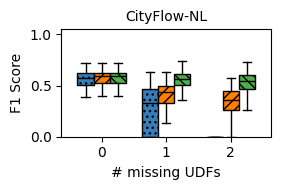

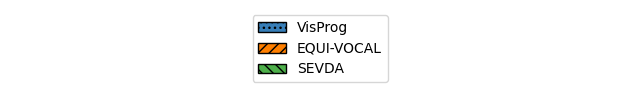

In [11]:
dataset = "cityflow"
dataset_title = "CityFlow-NL"
query_class_names = [
    "unavailable_pred=1-unavailable_attr_pred=1-npred=1-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737",
    "unavailable_pred=1-unavailable_attr_pred=1-npred=2-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737"
]
question_ids = list(range(15))
# question_ids = list(range(10))
# run_ids = list(range(3))
run_ids = list(range(3))
num_new_udfs = [0, 1, 2]
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-labels=user-budget=50-llm_method=gpt4v"

plot(dataset, dataset_title, query_class_names, num_new_udfs, question_ids, run_ids, vocal_udf_config_name)

######## visprog ########
task_0_new_udfs_mean_f1: 0.9955081186121507
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.6115581477435994
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.33316000518351646
task_2_new_udfs_prob_failures: 0.0

task_3_new_udfs_mean_f1: 0.189938648961312
task_3_new_udfs_prob_failures: 0.0

######## equi-vocal ########
task_0_new_udfs_mean_f1: 0.9997618401939169
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.7239608268962157
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.48694458873159147
task_2_new_udfs_prob_failures: 0.0

task_3_new_udfs_mean_f1: 0.3317128725102557
task_3_new_udfs_prob_failures: 0.0

######## vocal-udf ########
task_0_new_udfs_mean_f1: 0.9995904205274062
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.8752149440582287
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.7828146604304894
task_2_new_udfs_prob_failures: 0.0

task_3_new_udfs_mean_f1: 0.773692591

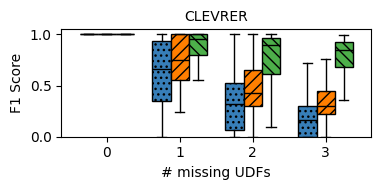

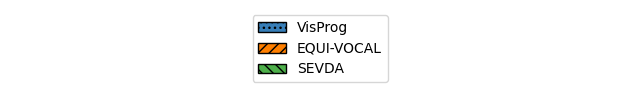

In [9]:
dataset = "clevrer"
dataset_title = "CLEVRER"
query_class_names = [
    "3_new_udfs_labels",
]
question_ids = list(range(30))
# question_ids = list(range(10))
# run_ids = list(range(3))
run_ids = list(range(3))
num_new_udfs = [0, 1, 2, 3]
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=both-labels=user-budget=20-llm_method=gpt4v"

plot(dataset, dataset_title, query_class_names, num_new_udfs, question_ids, run_ids, vocal_udf_config_name)

######## visprog ########
task_0_new_udfs_mean_f1: 0.6889678617884615
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.5172084055572428
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.3983703250581722
task_2_new_udfs_prob_failures: 0.0

######## equi-vocal ########
task_0_new_udfs_mean_f1: 0.6904632224516812
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.48359193190801875
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.41726897771929755
task_2_new_udfs_prob_failures: 0.0

######## vocal-udf ########
task_0_new_udfs_mean_f1: 0.6884787464373691
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.6162759678729458
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.5804808519486383
task_2_new_udfs_prob_failures: 0.0



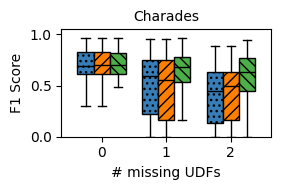

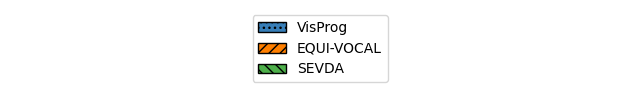

In [10]:
dataset = "charades"
dataset_title = "Charades"
query_class_names = [
    "unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2",
    "unavailable=2-npred=4-nobj_pred=1-nvars=2-depth=2",
    "unavailable=2-npred=3-nobj_pred=1-nvars=2-depth=2"
]
question_ids = list(range(10))
run_ids = list(range(3))
# run_ids = list(range(3))
num_new_udfs = [0, 1, 2]
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-labels=user-budget=50-llm_method=gpt4v"

plot(dataset, dataset_title, query_class_names, num_new_udfs, question_ids, run_ids, vocal_udf_config_name)